## Healthcon Variable and Frailty Index

#### Gavin Qu, May 30th - June 13th

#### Extract the hcond and disdif data, and handle missing values

In [89]:
import pandas as pd
import numpy as np
import os

# Base directory containing the data files
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Health condition variables for different waves
base_hcond_variables = ['hcond1', 'hcond2', 'hcond3', 'hcond4', 'hcond5', 'hcond6', 'hcond7', 'hcond8', 'hcond9', 'hcond10', 'hcond11', 'hcond12', 'hcond13', 'hcond14', 'hcond15', 'hcond16']
hcondn_variables = ['hcondn1', 'hcondn2', 'hcondn3', 'hcondn4', 'hcondn5', 'hcondn6', 'hcondn7', 'hcondn8', 'hcondn9', 'hcondn10', 'hcondn11', 'hcondn12', 'hcondn13', 'hcondn14', 'hcondn15', 'hcondn16']
hcondever_variables = ['hcondever1', 'hcondever2', 'hcondever3', 'hcondever4', 'hcondever5', 'hcondever6', 'hcondever7', 'hcondever8', 'hcondever9', 'hcondever10', 'hcondever11', 'hcondever12', 'hcondever13', 'hcondever14', 'hcondever15', 'hcondever16']
hcondnew_variables = ['hcondnew1', 'hcondnew2', 'hcondnew3', 'hcondnew4', 'hcondnew5', 'hcondnew6', 'hcondnew7', 'hcondnew8', 'hcondnew10', 'hcondnew11', 'hcondnew12', 'hcondnew13', 'hcondnew14', 'hcondnew15', 'hcondnew16']
disdif_variables = ['disdif1', 'disdif2', 'disdif3', 'disdif4', 'disdif5', 'disdif6', 'disdif7', 'disdif8', 'disdif9', 'disdif10', 'disdif11']

# Prefixes for wave variables
prefixes = list('abcdefghijklm')

# Function to load data for a single wave
def load_wave_data(prefix, variables):
    file_path = os.path.join(base_dir, f'{prefix}_indresp.dta')
    df = pd.read_stata(file_path, convert_categoricals=False)
    available_vars = [var for var in [f'{prefix}_{var}' for var in variables] if var in df.columns]
    required_vars = ['pidp'] + available_vars
    df = df[required_vars]
    return df

# Dictionary to store the variables per wave
variables_per_wave = {
    'a': base_hcond_variables + disdif_variables,
    'b': disdif_variables + hcondn_variables,
    'c': hcondn_variables + base_hcond_variables + disdif_variables,
    'd': hcondn_variables + base_hcond_variables + disdif_variables,
    'e': hcondn_variables + base_hcond_variables + disdif_variables,
    'f': hcondn_variables + base_hcond_variables + disdif_variables,
    'g': hcondn_variables + base_hcond_variables + disdif_variables,
    'h': hcondn_variables + base_hcond_variables + disdif_variables,
    'i': hcondn_variables + base_hcond_variables + disdif_variables,
    'j': hcondever_variables + base_hcond_variables + disdif_variables,
    'k': hcondnew_variables + base_hcond_variables + disdif_variables,
    'l': hcondnew_variables + base_hcond_variables + disdif_variables,
    'm': hcondnew_variables + base_hcond_variables + disdif_variables
}

# Load data for all waves
data_frames = []

for prefix in prefixes:
    variables = variables_per_wave[prefix]
    df = load_wave_data(prefix, variables)
    data_frames.append(df)

# Concatenate all data frames
df_all = pd.concat(data_frames, ignore_index=True)

# Replace negative values with NaN
df_all.replace({-1: np.nan, -2: np.nan, -3: np.nan, -4: np.nan, -5: np.nan, -6: np.nan, -7: np.nan, -8: np.nan, -9: np.nan}, inplace=True)

# Save combined DataFrame to a new CSV file without modifying NaN values
df_all.to_csv("combined_UKHLS_data.csv", index=False)

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1594726507.py:21: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1594726507.py:21: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata(file_path, convert_categoricals=False)


### Test for extracted dataset that print out the count of 1, 0 and NaN

In [90]:
import pandas as pd

# Load the extracted dataset
df = pd.read_csv("combined_UKHLS_data.csv")

# Get the list of variable names
variables = df.columns.tolist()

# Create a DataFrame to store the counts
counts_df = pd.DataFrame(columns=['variable', 'count_missing', 'count_1', 'count_0'])

# Iterate over each variable and count the values
for var in variables:
    count_missing = df[var].isna().sum()
    count_1 = df[var].eq(1).sum()
    count_0 = df[var].eq(0).sum()
    
    new_row = pd.DataFrame({
        'variable': [var],
        'count_missing': [count_missing],
        'count_1': [count_1],
        'count_0': [count_0]
    })
    
    counts_df = pd.concat([counts_df, new_row], ignore_index=True)

# Print the counts for each variable
print(counts_df)

       variable count_missing count_1 count_0
0          pidp             0       0       0
1      a_hcond1        485871    6269   41336
2      a_hcond2        485871    6769   40836
3      a_hcond3        485871     276   47329
4      a_hcond4        485871     854   46751
..          ...           ...     ...     ...
515   m_disdif7        505667     299   27510
516   m_disdif8        505667    1167   26642
517   m_disdif9        505667     185   27624
518  m_disdif10        505667    1312   26497
519  m_disdif11        505667    1022   26787

[520 rows x 4 columns]


### Constructing {prefix}_healthcond1-16 Variables

In [96]:
import pandas as pd
import numpy as np

# Load the extracted dataset
df_all = pd.read_csv("combined_UKHLS_data.csv")

# Initialize the healthcond columns with NaN values for all waves
for prefix in list('abcdefghijklm'):
    for i in range(1, 17):
        df_all[f"{prefix}_healthcond{i}"] = np.nan

# Iterate over each prefix and apply the logic to create healthcond variables
for prefix in list('abcdefghijklm'):
    for i in range(1, 17):
        hcond_col = f"{prefix}_hcond{i}"
        hcondn_col = f"{prefix}_hcondn{i}"
        hcondnew_col = f"{prefix}_hcondnew{i}"
        hcondever_col = f"{prefix}_hcondever{i}"
        healthcond_col = f"{prefix}_healthcond{i}"

        if prefix == 'a':
            if hcond_col in df_all.columns:
                df_all.loc[df_all[hcond_col] == 1, healthcond_col] = 1
                df_all.loc[df_all[hcond_col] == 0, healthcond_col] = 0
        else:
            prev_prefix = chr(ord(prefix) - 1)
            prev_healthcond_col = f"{prev_prefix}_healthcond{i}"

            # Check if hcondever_col exists for wave 'j'
            if prefix == 'j' and hcondever_col in df_all.columns:
                df_all.loc[(df_all[prev_healthcond_col].isna()) & (df_all[hcondever_col] == 1), healthcond_col] = 1
                df_all.loc[(df_all[prev_healthcond_col].isna()) & (df_all[hcondever_col] == 0), healthcond_col] = 0

            # Update healthcond based on previous wave and current wave responses
            if hcondn_col in df_all.columns:
                df_all.loc[(df_all[prev_healthcond_col] == 1) | (df_all[hcondn_col] == 1), healthcond_col] = 1
                df_all.loc[(df_all[prev_healthcond_col] == 0) & (df_all[hcondn_col] == 0), healthcond_col] = 0
            elif hcondnew_col in df_all.columns:
                df_all.loc[(df_all[prev_healthcond_col] == 1) | (df_all[hcondnew_col] == 1), healthcond_col] = 1
                df_all.loc[(df_all[prev_healthcond_col] == 0) & (df_all[hcondnew_col] == 0), healthcond_col] = 0

# Save the updated DataFrame to a new CSV file
df_all.to_csv("combined_UKHLS_data_updated.csv", index=False)

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1546423590.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f"{prefix}_healthcond{i}"] = np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1546423590.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all[f"{prefix}_healthcond{i}"] = np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1546423590.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

#### Count the values of healthcond when they are 1, 0 and missing. 

In [97]:
import pandas as pd

# Load the updated dataset
df_all = pd.read_csv("combined_UKHLS_data_updated.csv")

# Get the list of prefixes from the column names
prefixes = sorted(set(col[0] for col in df_all.columns if len(col) > 1))

# Create an empty DataFrame to store the counts
counts_df = pd.DataFrame(columns=['variable', 'count_1', 'count_0', 'count_missing'])

# Iterate over each prefix and count the values for each healthcond variable
for prefix in prefixes:
    for i in range(1, 17):
        healthcond_col = f"{prefix}_healthcond{i}"
        
        if healthcond_col in df_all.columns:
            count_1 = df_all[healthcond_col].eq(1).sum()
            count_0 = df_all[healthcond_col].eq(0).sum()
            count_missing = df_all[healthcond_col].isna().sum()
            
            new_row = pd.DataFrame({
                'variable': [healthcond_col],
                'count_1': [count_1],
                'count_0': [count_0],
                'count_missing': [count_missing]
            })
            
            counts_df = pd.concat([counts_df, new_row], ignore_index=True)

# Print the counts for each healthcond variable by wave
print(counts_df)

           variable count_1 count_0 count_missing
0     a_healthcond1    6269   41336        485871
1     a_healthcond2    6769   40836        485871
2     a_healthcond3     276   47329        485871
3     a_healthcond4     854   46751        485871
4     a_healthcond5    1353   46252        485871
..              ...     ...     ...           ...
203  m_healthcond12     754       0        532722
204  m_healthcond13    2380       0        531096
205  m_healthcond14    4263       0        529213
206  m_healthcond15     450       0        533026
207  m_healthcond16    8785       0        524691

[208 rows x 4 columns]


### Add age and death data

In [98]:
import pandas as pd
import os

# Base directory containing the data
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# Load the combined data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/combined_UKHLS_data_updated.csv")

# Load the death data from xwavedat.dta
xwave_df = pd.read_stata(os.path.join(base_dir, 'xwavedat.dta'))

# Mapping wave number to death value
death_mapping = {
    'UKHLS Wave 20': 'b', 'UKHLS Wave 21': 'c', 'UKHLS Wave 22': 'd', 'UKHLS Wave 23': 'e', 
    'UKHLS Wave 24': 'f', 'UKHLS Wave 25': 'g', 'UKHLS Wave 26': 'h', 'UKHLS Wave 27': 'i', 
    'UKHLS Wave 28': 'j', 'UKHLS Wave 29': 'k', 'UKHLS Wave 30': 'l', 'UKHLS Wave 31': 'm'
}

# Merge death data to df_all
df_all = df_all.merge(xwave_df[['pidp', 'dcsedw_dv']], on='pidp', how='left')

# Load age_dv data for each wave and merge with df_all
def load_and_merge_age_data(df, base_dir, prefixes):
    for prefix in prefixes:
        file_path = os.path.join(base_dir, f'{prefix}_indresp.dta')
        if os.path.exists(file_path):
            wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])
            df = df.merge(wave_df, on='pidp', how='left')
    return df

# Add age variable for each wave
prefixes = list('abcdefghijklm')
df_all = load_and_merge_age_data(df_all, base_dir, prefixes)

# Function to mark death in the relevant waves
def mark_death(df, death_mapping):
    for wave, wave_prefix in death_mapping.items():
        df[f'{wave_prefix}_death'] = df['dcsedw_dv'].apply(lambda x: 1 if x == wave else 0)
    return df

# Mark death in the relevant waves
df_all = mark_death(df_all, death_mapping)

# Save the updated DataFrame to a new CSV file
df_all.to_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv", index=False)


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1327312461.py:28: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/1327312461.py:28: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_df = pd.read_stata(file_path, columns=['pidp', f'{prefix}_age_dv'])


####  Check Death Count and Valid Age Data

In [99]:
import pandas as pd

# Load the updated data
df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv")

# Function to calculate death count and check valid age data for each wave
def check_death_count_and_age_data(df, prefixes):
    death_counts = {}
    age_validity = {}

    for prefix in prefixes:
        death_var = f'{prefix}_death'
        age_var = f'{prefix}_age_dv'
        
        if death_var in df.columns:
            death_counts[prefix] = df[death_var].sum()
        
        if age_var in df.columns:
            valid_age_count = df[age_var].notna().sum()
            total_count = df[age_var].shape[0]
            age_validity[prefix] = f'{valid_age_count} out of {total_count} have valid age data'

    return death_counts, age_validity

# Define prefixes
prefixes = list('abcdefghijklm')

# Check death count and age data validity
death_counts, age_validity = check_death_count_and_age_data(df_all, prefixes)

# Print the results
print("Death Counts for Each Wave:")
for prefix, count in death_counts.items():
    print(f"Wave {prefix.upper()}: {count}")

print("\nAge Data Validity for Each Wave:")
for prefix, validity in age_validity.items():
    print(f"Wave {prefix.upper()}: {validity}")


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/2766674067.py:4: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv")


Death Counts for Each Wave:
Wave B: 233
Wave C: 564
Wave D: 957
Wave E: 1090
Wave F: 1438
Wave G: 1971
Wave H: 2379
Wave I: 2357
Wave J: 2605
Wave K: 2745
Wave L: 2902
Wave M: 3225

Age Data Validity for Each Wave:
Wave A: 337477 out of 533476 have valid age data
Wave B: 423039 out of 533476 have valid age data
Wave C: 421983 out of 533476 have valid age data
Wave D: 422124 out of 533476 have valid age data
Wave E: 416114 out of 533476 have valid age data
Wave F: 414007 out of 533476 have valid age data
Wave G: 404375 out of 533476 have valid age data
Wave H: 390028 out of 533476 have valid age data
Wave I: 369078 out of 533476 have valid age data
Wave J: 355787 out of 533476 have valid age data
Wave K: 335468 out of 533476 have valid age data
Wave L: 309260 out of 533476 have valid age data
Wave M: 292212 out of 533476 have valid age data


We see here that the death count is correct and it reflects the official counts of the UKHLS. Note: The above count is cumulative of all previous and current waves. 

### Frailty index with death counted as 1 using the healthcond and disdiff variables

In [100]:
import pandas as pd
import numpy as np

# Define the base directory and file paths
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_age_and_death.csv"
output_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Define the health condition and difficulty with daily task variables
health_cond_vars = [f'healthcond{i}' for i in range(1, 17)]
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
prefixes = list('abcdefghijklm')

# Function to compute frailty index for each wave
def compute_frailty_index(df, prefixes):
    for prefix in prefixes:
        health_vars = [f'{prefix}_{var}' for var in health_cond_vars]
        disdif_vars = [f'{prefix}_disdif{i}' for i in range(1, 12)]
        all_vars = health_vars + disdif_vars
        
        # Ensure all necessary columns are present
        present_vars = [var for var in all_vars if var in df.columns]

        # Compute the frailty index
        def calculate_frailty(row):
            # Check if the person is marked as dead
            if prefix != 'a' and row.get(f'{prefix}_death') == 1:
                return 1.0
            values = row[present_vars]
            # Only calculate frailty if not all values are NaN or negative
            if all(pd.isna(v) or v < 0 for v in values):
                return np.nan
            # Calculate frailty score excluding NaNs and negatives
            valid_values = [v for v in values if v >= 0 and not pd.isna(v)]
            frailty_score = sum(valid_values) / len(present_vars)
            return frailty_score

        df[f'{prefix}_frailty'] = df.apply(calculate_frailty, axis=1)
    
    # Propagate death frailty to subsequent waves
    for prefix in prefixes:
        if prefix != 'a':  # skip wave 'a' for death check
            death_indices = df[df[f'{prefix}_death'] == 1].index
            for next_prefix in prefixes[prefixes.index(prefix)+1:]:
                df.loc[death_indices, f'{next_prefix}_frailty'] = 1.0

    return df

# Process the data in chunks to manage memory usage effectively
chunk_size = 10000  # Adjust chunk size based on memory availability
first_chunk = True

for df_chunk in pd.read_csv(data_file, chunksize=chunk_size, low_memory=False):
    df_chunk = compute_frailty_index(df_chunk, prefixes)
    if first_chunk:
        df_chunk.to_csv(output_file, index=False, mode='w', header=True)
        first_chunk = False
    else:
        df_chunk.to_csv(output_file, index=False, mode='a', header=False)

### Total count of frailty by wave

In [101]:
import pandas as pd

# Path to the file containing frailty data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"

# Read the data
df = pd.read_csv(data_file)

# List of waves
prefixes = list('abcdefghijklm')

# Checking for duplicates for each wave based on 'pidp'
for prefix in prefixes:
    pidp_col = f'{prefix}_pidp'  # assuming pidp is named like 'a_pidp', 'b_pidp', etc.
    if pidp_col in df.columns:
        initial_count = df[pidp_col].count()
        df.drop_duplicates(subset=[pidp_col], inplace=True)
        final_count = df[pidp_col].count()
        if initial_count != final_count:
            print(f"Duplicate entries found and removed in wave {prefix.upper()}.")

# Initialize a dictionary to store the results
frailty_stats = {}

# Compute statistics for each wave
for prefix in prefixes:
    frailty_var = f'{prefix}_frailty'
    if frailty_var in df.columns:
        # Calculate counts for different frailty conditions
        zero_frailty = (df[frailty_var] == 0).sum()
        positive_frailty = ((df[frailty_var] > 0) & (df[frailty_var] < 1)).sum()
        missing_frailty = df[frailty_var].isna().sum()
        one_frailty = (df[frailty_var] == 1).sum()

        # Store the counts in the dictionary
        frailty_stats[prefix] = {
            'Zero Frailty': zero_frailty,
            'Positive Frailty': positive_frailty,
            'Missing Frailty': missing_frailty,
            'Frailty == 1': one_frailty
        }

# Output the results
print("Frailty Counts for Each Wave:")
for prefix, stats in frailty_stats.items():
    print(f"Wave {prefix.upper()}:")
    for condition, count in stats.items():
        print(f"  {condition}: {count}")
    print()



/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/3760021513.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Frailty Counts for Each Wave:
Wave A:
  Zero Frailty: 24021
  Positive Frailty: 23600
  Missing Frailty: 485855
  Frailty == 1: 0

Wave B:
  Zero Frailty: 5827
  Positive Frailty: 34657
  Missing Frailty: 492759
  Frailty == 1: 233

Wave C:
  Zero Frailty: 5481
  Positive Frailty: 38679
  Missing Frailty: 488519
  Frailty == 1: 797

Wave D:
  Zero Frailty: 5366
  Positive Frailty: 41756
  Missing Frailty: 484600
  Frailty == 1: 1754

Wave E:
  Zero Frailty: 4869
  Positive Frailty: 44429
  Missing Frailty: 481334
  Frailty == 1: 2844

Wave F:
  Zero Frailty: 5307
  Positive Frailty: 47115
  Missing Frailty: 476772
  Frailty == 1: 4282

Wave G:
  Zero Frailty: 5340
  Positive Frailty: 49601
  Missing Frailty: 472282
  Frailty == 1: 6253

Wave H:
  Zero Frailty: 27230
  Positive Frailty: 53027
  Missing Frailty: 444587
  Frailty == 1: 8632

Wave I:
  Zero Frailty: 25273
  Positive Frailty: 55636
  Missing Frailty: 441578
  Frailty == 1: 10989

Wave J:
  Zero Frailty: 17434
  Positive Fra

### Mean and Median of Frailty by Wave

In [105]:
import pandas as pd

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Initialize a dictionary to store results
frailty_stats = {}

# Loop over each wave to calculate mean, median, and mode frailty
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    
    if frailty_col in df.columns:
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')  # Convert to numeric, coercing errors
        
        # Filter out NaN values
        valid_frailty = df[frailty_col].dropna()
        
        # Calculate mean, median, and mode
        mean_frailty = valid_frailty.mean()
        median_frailty = valid_frailty.median()
        mode_frailty = valid_frailty.mode().tolist()  # Convert mode to a list
        
        # Store the results
        frailty_stats[prefix] = {'mean': mean_frailty, 'median': median_frailty, 'mode': mode_frailty}

# Print out the results
print("Mean, Median, and Mode Frailty by Wave:")
for prefix, stats in frailty_stats.items():
    print(f"Wave {prefix.upper()}: Mean = {stats['mean']}, Median = {stats['median']}, Mode = {stats['mode']}")

### Distribution of Age

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/4282210731.py:7: DtypeWarning: Columns (427,428,431,432,434,435,436,437,438) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


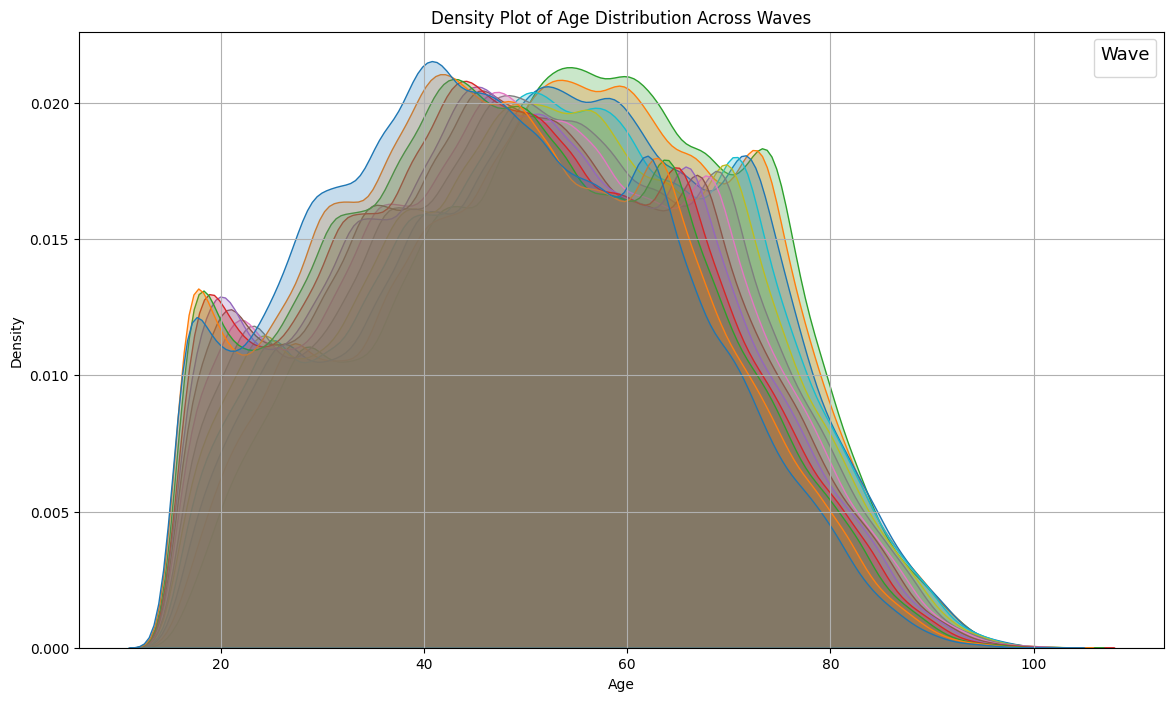

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for plotting
age_data = pd.DataFrame()

# Loop over each wave to extract age data
for prefix in wave_prefixes:
    age_col = f'{prefix}_age_dv'

    # Check if the age column is in the dataframe
    if age_col in df.columns:
        df[age_col] = pd.to_numeric(df[age_col], errors='coerce')  # Convert to numeric, coercing errors
        # Collect age data into a single dataframe for plotting
        temp_df = df[['pidp', age_col]].dropna()  # Drop NaN values which can be from conversion or missing data
        temp_df = temp_df.rename(columns={age_col: 'age'})
        temp_df['wave'] = prefix  # Label each row with its wave for group by in plot
        age_data = pd.concat([age_data, temp_df], ignore_index=True)

# Create a density plot using seaborn
plt.figure(figsize=(14, 8))
sns.kdeplot(data=age_data, x='age', hue='wave', common_norm=False, palette='tab10', fill=True)
plt.title('Density Plot of Age Distribution Across Waves')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.legend(title='Wave', title_fontsize='13', fontsize='11')
plt.show()


### Density Plot of Frailty

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/2691889958.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


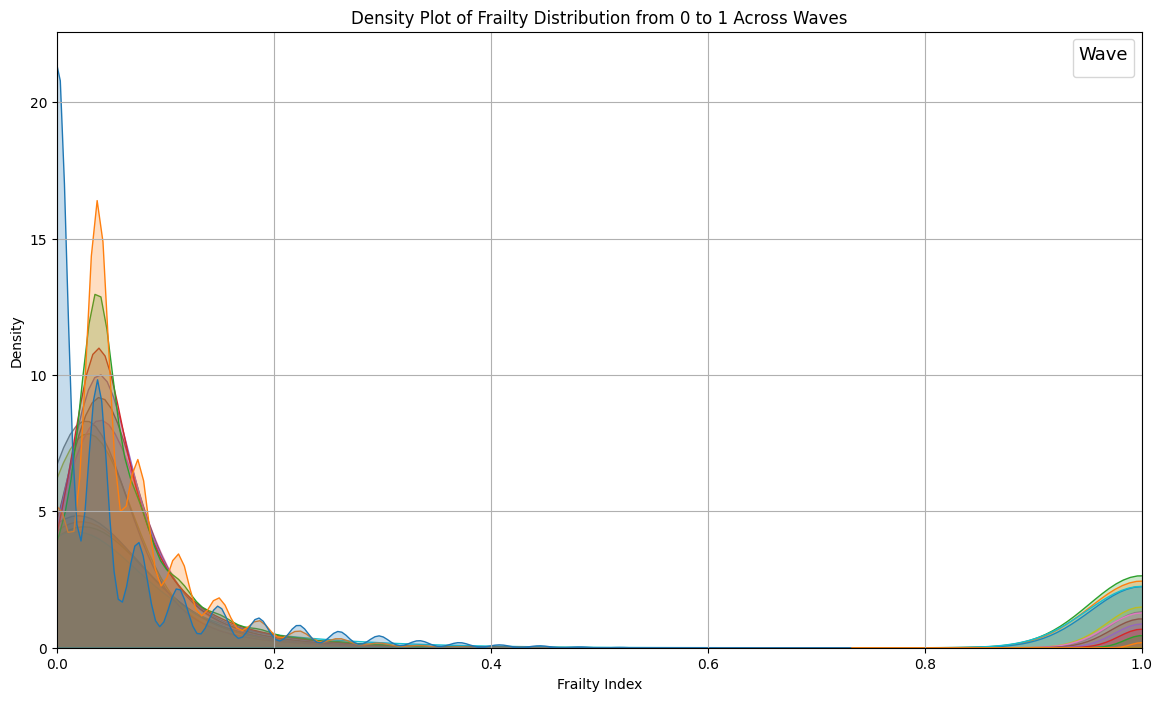

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for plotting
frailty_data = pd.DataFrame()

# Loop over each wave to extract frailty data
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'

    # Check if the frailty column is in the dataframe
    if frailty_col in df.columns:
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')  # Convert to numeric, coercing errors
        # Filter to include only values between 0 and 1
        temp_df = df[['pidp', frailty_col]].dropna()  # Drop NaN values
        temp_df = temp_df[(temp_df[frailty_col] >= 0) & (temp_df[frailty_col] <= 1)]  # Ensure range is 0 to 1
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index'})
        temp_df['wave'] = prefix  # Label each row with its wave for group by in plot
        frailty_data = pd.concat([frailty_data, temp_df], ignore_index=True)

# Create a density plot using seaborn for the frailty index
plt.figure(figsize=(14, 8))
sns.kdeplot(data=frailty_data, x='frailty_index', hue='wave', common_norm=False, palette='tab10', fill=True)
plt.title('Density Plot of Frailty Distribution from 0 to 1 Across Waves')
plt.xlabel('Frailty Index')
plt.ylabel('Density')
plt.grid(True)
plt.legend(title='Wave', title_fontsize='13', fontsize='11')
plt.xlim(0, 1)  # Ensure the x-axis is limited to 0 to 1
plt.show()


### Smoothed Line Plot of Frailty against Age excluding missing value

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/723766492.py:7: DtypeWarning: Columns (730,731,734,735,737,738,739,740,741) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/723766492.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd', estimator='mean')


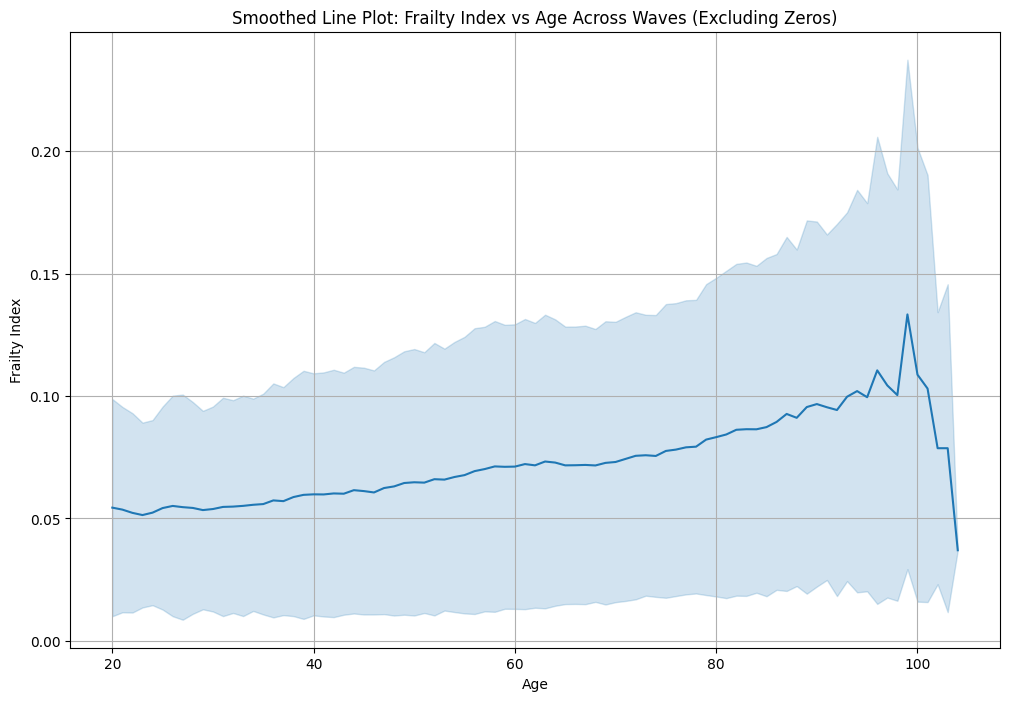

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# List of wave prefixes to process
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]  # Generates 'a' to 'm'

# Prepare data for the plot
scatter_data = pd.DataFrame()

# Loop over each wave to extract and prepare data
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    
    # Check if the columns are in the dataframe
    if frailty_col in df.columns and age_col in df.columns:
        # Convert to numeric, coercing errors
        df[frailty_col] = pd.to_numeric(df[frailty_col], errors='coerce')
        df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
        
        # Extract the relevant columns
        temp_df = df[['pidp', frailty_col, age_col]].copy()
        # Rename columns for consistency
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        # Filter out invalid frailty indices, excluding zeros and including only age >= 20
        temp_df = temp_df[(temp_df['frailty_index'].notna()) & (temp_df['frailty_index'] > 0) & (temp_df['age'] >= 20)]
        
        # Add data to the scatter plot DataFrame
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create a smoothed line plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd', estimator='mean')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves (Excluding Zeros)')
plt.grid(True)
plt.show()

### Plot of non-zero and non-missing Disdif and Healthcond

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_1740/3261819921.py:7: DtypeWarning: Columns (427,428,431,432,434,435,436,437,438) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


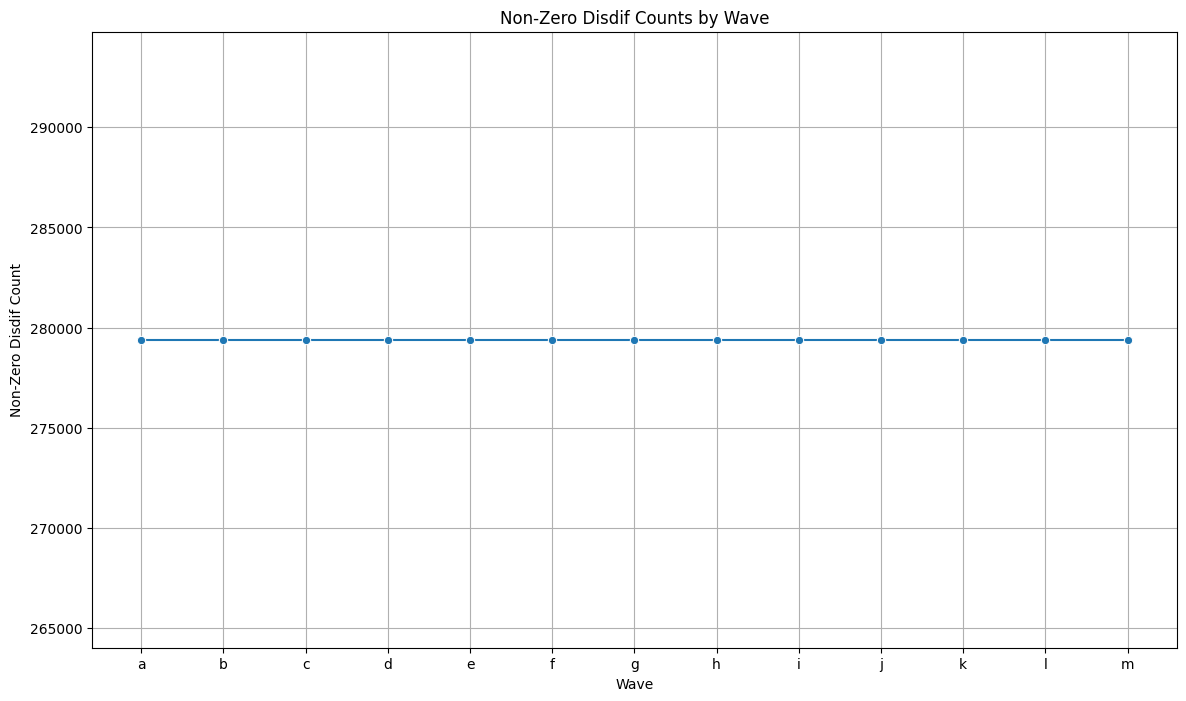

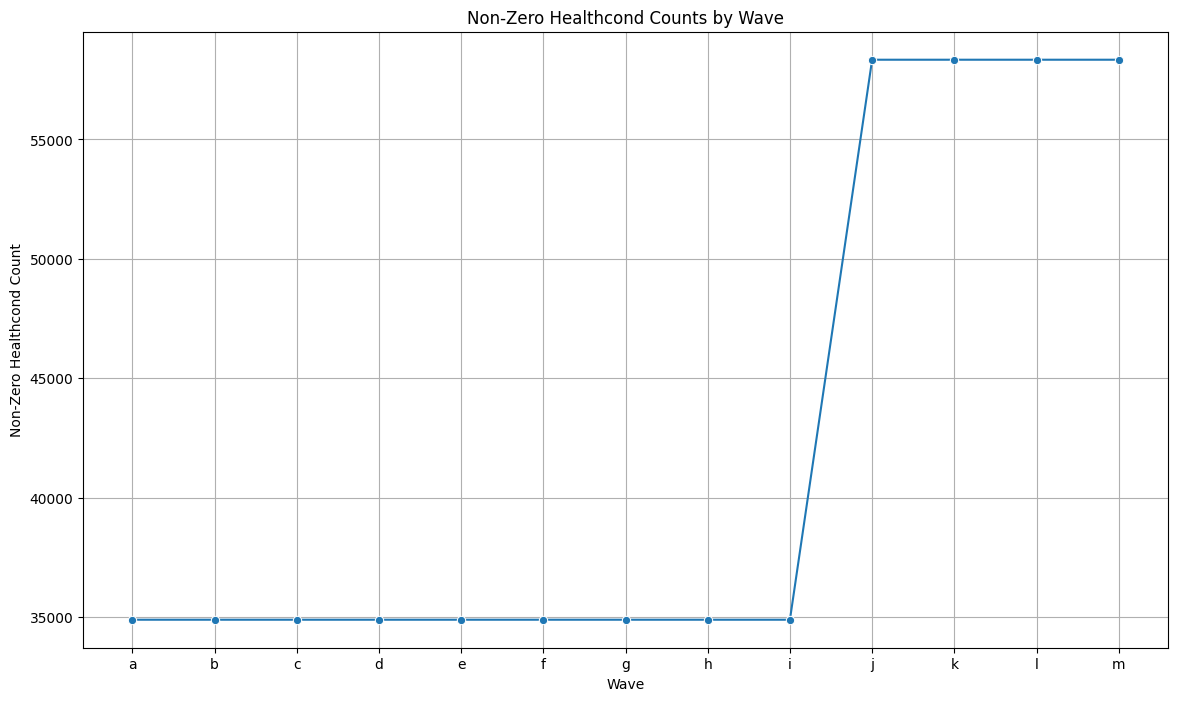

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_with_frailty.csv"
df = pd.read_csv(data_file)

# Define the waves and variable prefixes
waves = list('abcdefghijklm')  # Assuming waves 'a' through 'm'
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
healthcond_vars = [f'healthcond{i}' for i in range(1, 17)]

# Prepare dataframes for storing counts
non_zero_disdif_counts = []
non_zero_healthcond_counts = []

# Calculate non-zero/non-missing counts for each wave
for wave in waves:
    wave_disdif_counts = df[[f'{wave}_{var}' for var in disdif_vars]].apply(lambda x: x[(x > 0) & (~x.isna())].count())
    wave_healthcond_counts = df[[f'{wave}_{var}' for var in healthcond_vars]].apply(lambda x: x[(x > 0) & (~x.isna())].count())

    non_zero_disdif_counts.append(wave_disdif_counts.sum())
    non_zero_healthcond_counts.append(wave_healthcond_counts.sum())

# Create DataFrames from the counts
non_zero_disdif_counts_df = pd.DataFrame(non_zero_disdif_counts, index=waves, columns=['Non-Zero Disdif'])
non_zero_healthcond_counts_df = pd.DataFrame(non_zero_healthcond_counts, index=waves, columns=['Non-Zero Healthcond'])

# Plotting Non-Zero Disdif Counts by Wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_disdif_counts_df, x=non_zero_disdif_counts_df.index, y='Non-Zero Disdif', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Disdif Count')
plt.title('Non-Zero Disdif Counts by Wave')
plt.grid(True)
plt.show()

# Plotting Non-Zero Healthcond Counts by Wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_healthcond_counts_df, x=non_zero_healthcond_counts_df.index, y='Non-Zero Healthcond', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Healthcond Count')
plt.title('Non-Zero Healthcond Counts by Wave')
plt.grid(True)
plt.show()


### Plot disdif and healthcond Values

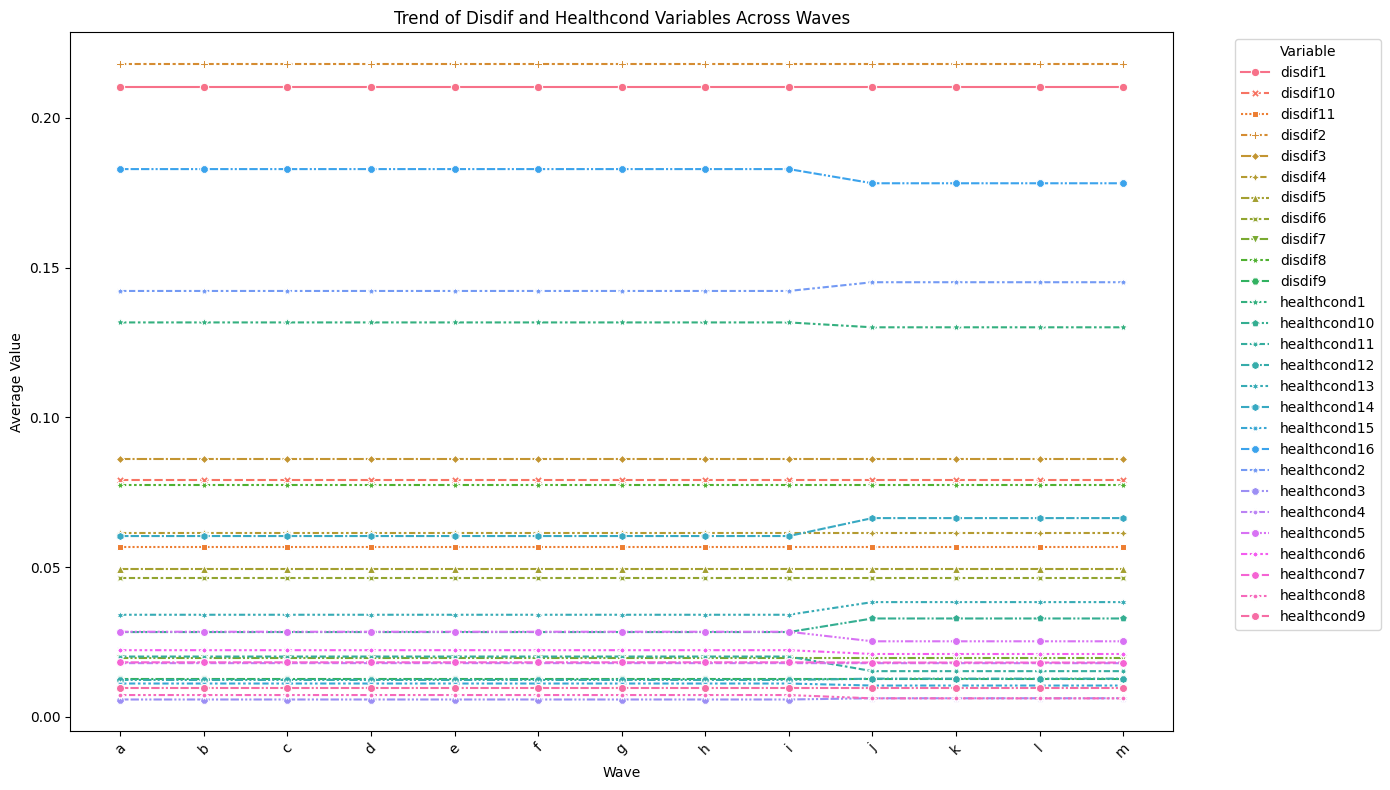

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_file = "/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/updated_UKHLS_data.csv"
df = pd.read_csv(data_file)

# List the waves and the types of variables you want to plot
waves = list('abcdefghijklm')
disdif_vars = [f'disdif{i}' for i in range(1, 12)]
healthcond_vars = [f'healthcond{i}' for i in range(1, 17)]

# Create an empty list to store DataFrame snippets for later concatenation
data_frames = []

# Process each wave to aggregate or select data
for wave in waves:
    for var in disdif_vars + healthcond_vars:
        # Check if the specific variable exists in this wave
        column_name = f'{wave}_{var}'
        if column_name in df.columns:
            # Calculate the mean of each variable in each wave across all individuals
            mean_value = df[column_name].mean()
            # Append a new DataFrame with the result
            data_frames.append(pd.DataFrame({'Wave': [wave], 'Variable': [var], 'Value': [mean_value]}))

# Concatenate all DataFrame snippets into a single DataFrame
plot_data = pd.concat(data_frames, ignore_index=True)

# Pivot the data for plotting
plot_data_pivot = plot_data.pivot(index="Wave", columns="Variable", values="Value")

# Plotting using line plots
plt.figure(figsize=(14, 8))
sns.lineplot(data=plot_data_pivot, markers=True)
plt.xticks(rotation=45)
plt.ylabel('Average Value')
plt.title('Trend of Disdif and Healthcond Variables Across Waves')
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
